# GeoPackage

## Modules and versions

In [1]:
# import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import fiona
import os
import sys

In [2]:
# python version
pd.DataFrame(
    {'version': [f'{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}']}, 
    index=['python']
)

,version
python,3.11.10


In [3]:
# module versions
modules = ['numpy', 'pandas', 'geopandas', 'fiona', 'matplotlib', 'requests']
pd.DataFrame({'version': [sys.modules[m].__version__ for m in modules]}, index=modules)

,version
numpy,2.2.5
pandas,2.2.3
geopandas,1.0.1
fiona,1.10.1
matplotlib,3.10.3
requests,2.32.3


## Download and extract GeoPackage

source: https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2025

In [4]:
# download and extract zipped geopackage when geopackage does not exist
gpkg_url = 'https://download.cbs.nl/regionale-kaarten/WijkBuurtkaart_2025_v0.zip'
gpkg_file = gpkg_url.split('/')[-1].replace('zip', 'gpkg')

if not os.path.isfile(gpkg_file):
    
    # request geopackage zipfile
    r = requests.get(gpkg_url, allow_redirects=True)
    
    # write geopackage zipfile
    file_name = gpkg_url.split('/')[-1]
    open(file_name, 'wb').write(r.content)
    
    # extract geopackage zipfile in current folder
    with zipfile.ZipFile(file_name, 'r') as zipObj:
        zipObj.extractall()

## Create GeoDataFrame

In [5]:
# list geopackage layers
fiona.listlayers(gpkg_file)

['buurten_v0', 'gemeenten_v0', 'wijken_v0']

In [6]:
# read geopackage layer
gdf = gpd.read_file(gpkg_file, layer = 'gemeenten_v0')

In [7]:
# geodataframe info
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      424 non-null    int64   
 1   jrstatcode    424 non-null    object  
 2   gm_code       424 non-null    object  
 3   gm_naam       424 non-null    object  
 4   water         424 non-null    object  
 5   jaar          424 non-null    object  
 6   SHAPE_Length  424 non-null    float64 
 7   SHAPE_Area    424 non-null    float64 
 8   geometry      424 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 29.9+ KB


In [8]:
# geodataframe sample
gdf.sample(n=5, random_state=123)

,OBJECTID,jrstatcode,gm_code,gm_naam,water,jaar,SHAPE_Length,SHAPE_Area,geometry
13,14,2025GM1709,GM1709,Moerdijk,JA,2025,92015.334584,2.043620e+07,"MULTIPOLYGON (((103856.33 414192.29, 103856.31..."
121,122,2025GM0312,GM0312,Bunnik,NEE,2025,34607.820704,3.756914e+07,"MULTIPOLYGON (((141571.721 450542.791, 141542...."
267,268,2025GM0845,GM0845,Sint-Michielsgestel,NEE,2025,52829.042190,5.934151e+07,"MULTIPOLYGON (((153890.437 404905.639, 153902...."
196,197,2025GM0796,GM0796,'s-Hertogenbosch,NEE,2025,70271.839837,1.178118e+08,"MULTIPOLYGON (((150868.578 409397.761, 150854...."
165,166,2025GM0376,GM0376,Blaricum,JA,2025,20836.726237,4.435452e+06,"MULTIPOLYGON (((149547.68 479872.31, 149965.98..."


In [9]:
# unique values
gdf.water.unique()

array(['NEE', 'JA', 'B'], dtype=object)

In [10]:
# value counts
gdf.water.value_counts()

water
NEE    342
JA      81
B        1
Name: count, dtype: int64

In [11]:
# buitenland
gdf[gdf.water == 'B']

,OBJECTID,jrstatcode,gm_code,gm_naam,water,jaar,SHAPE_Length,SHAPE_Area,geometry
373,374,2025GM0998,GM0998,Buitenland,B,2025,34391.714286,2.344514e+06,"MULTIPOLYGON (((122416.41 383920.76, 122395.38..."


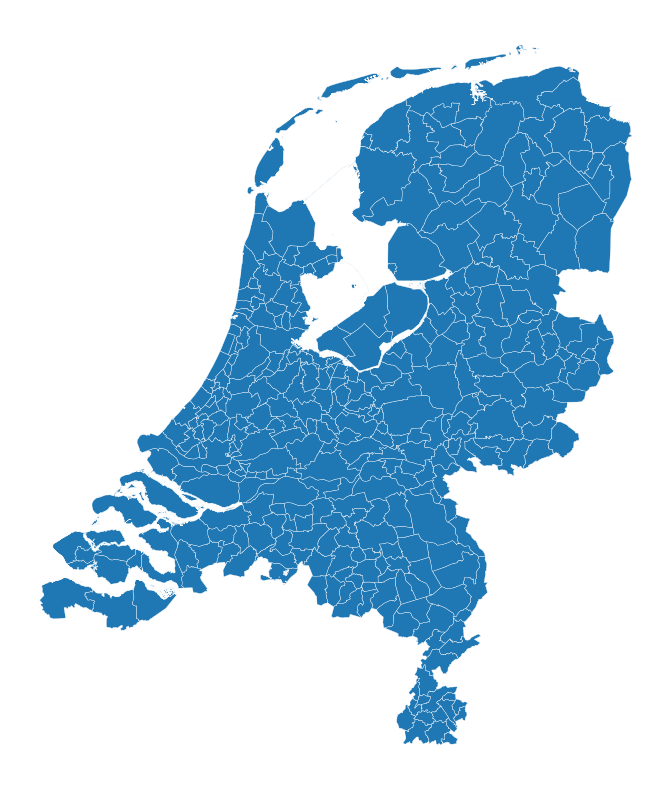

In [12]:
# plot empty map
gdf[gdf.water == 'NEE'].plot(figsize=(10, 10), linewidth=.25, edgecolor='white')
plt.axis('off')
plt.show()

## Add data

source: https://www.cbs.nl/nl-nl/maatwerk/2025/10/voorlopige-bevolkingsaantallen-per-gemeente-1-1-2025

In [13]:
# download excel file
xlsx_url = 'https://www.cbs.nl/-/media/_excel/2025/10/voorlopige-bevolkings-gegevens-20250101.xlsx'
xlsx_file = xlsx_url.split('/')[-1]

if not os.path.isfile(xlsx_file):
    
    # request excel file
    r = requests.get(xlsx_url, allow_redirects=True)
    
    # write excel file
    open(xlsx_file, 'wb').write(r.content)

In [14]:
# read excel file

df = pd.read_excel(
    xlsx_file, 
    sheet_name='Tabel 1', 
    skiprows=10, 
    usecols=[0, 1, 3], 
    names=['Gemeentecode', 'Gemeentenaam', 'Bevolking'])

df.tail()

,Gemeentecode,Gemeentenaam,Bevolking
337,1979,Eemsdelta,44795
338,1980,Dijk en Waard,90747
339,1982,Land van Cuijk,92817
340,1991,Maashorst,59671
341,1992,Voorne aan Zee,74527


In [15]:
# merge data
gdf.gm_code = gdf.gm_code.str.strip('GM').astype('int')
dfm = pd.merge(gdf[gdf.water == 'NEE'], df, how='left', left_on='gm_code', right_on='Gemeentecode')
dfm.sample(n=3)

,OBJECTID,jrstatcode,gm_code,gm_naam,water,jaar,SHAPE_Length,SHAPE_Area,geometry,Gemeentecode,Gemeentenaam,Bevolking
164,210,2025GM0439,439,Purmerend,NEE,2025,56265.010843,9.662702e+07,"MULTIPOLYGON (((125565.045 499558.77, 125558.3...",439,Purmerend,95912
234,294,2025GM0432,432,Opmeer,NEE,2025,32523.150986,4.194340e+07,"MULTIPOLYGON (((123954.918 521523.537, 123953....",432,Opmeer,12491
287,358,2025GM0971,971,Stein (L.),NEE,2025,30709.666925,2.279979e+07,"MULTIPOLYGON (((180653.755 327248.988, 180652....",971,Stein,24653


In [16]:
# geodataframe info
dfm.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      342 non-null    int64   
 1   jrstatcode    342 non-null    object  
 2   gm_code       342 non-null    int64   
 3   gm_naam       342 non-null    object  
 4   water         342 non-null    object  
 5   jaar          342 non-null    object  
 6   SHAPE_Length  342 non-null    float64 
 7   SHAPE_Area    342 non-null    float64 
 8   geometry      342 non-null    geometry
 9   Gemeentecode  342 non-null    int64   
 10  Gemeentenaam  342 non-null    object  
 11  Bevolking     342 non-null    int64   
dtypes: float64(2), geometry(1), int64(4), object(5)
memory usage: 32.2+ KB


## Plot maps

### Bevolkingsaantallen

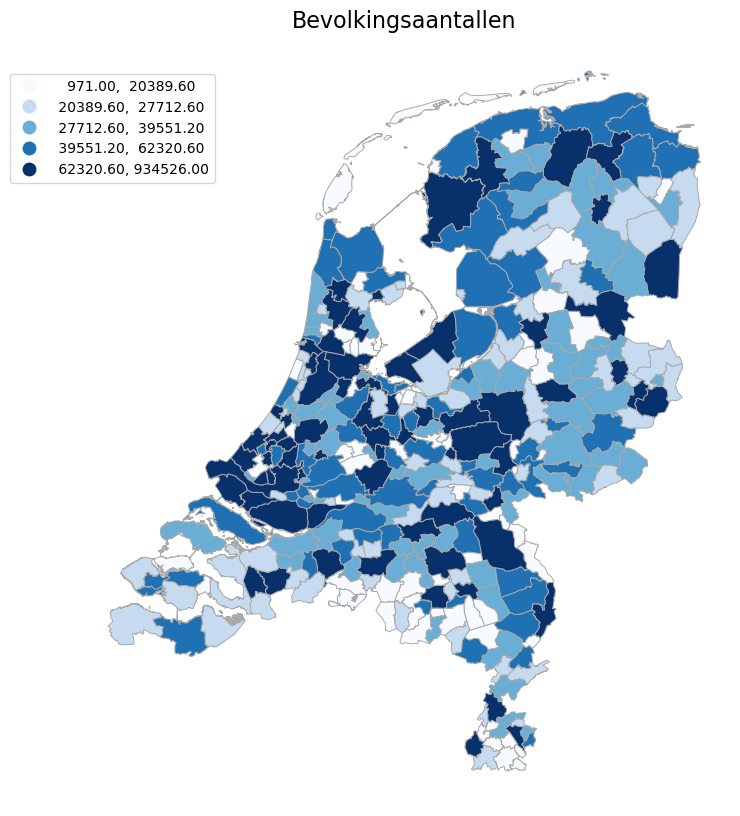

In [17]:
# plot map
column = 'Bevolking'
title = 'Bevolkingsaantallen'

f, ax = plt.subplots(1, figsize=(10, 10))

ax = dfm.plot(
    ax=ax, 
    linewidth=.7, 
    edgecolor='darkgrey', 
    cmap='Blues', 
    column=column, 
    legend=True, 
    scheme='quantiles', 
    missing_kwds={'color': 'lightgrey', 'label': 'Missing values'}
)

ax.set_title(title, fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.22, -0.04, 0, 1))
plt.axis('off')
plt.show()

### Bevolkingsdichtheid

In [18]:
# add bevolkingsdichtheid

dfm['Dichtheid'] = dfm['Bevolking'] / dfm['SHAPE_Area'] * 10_000

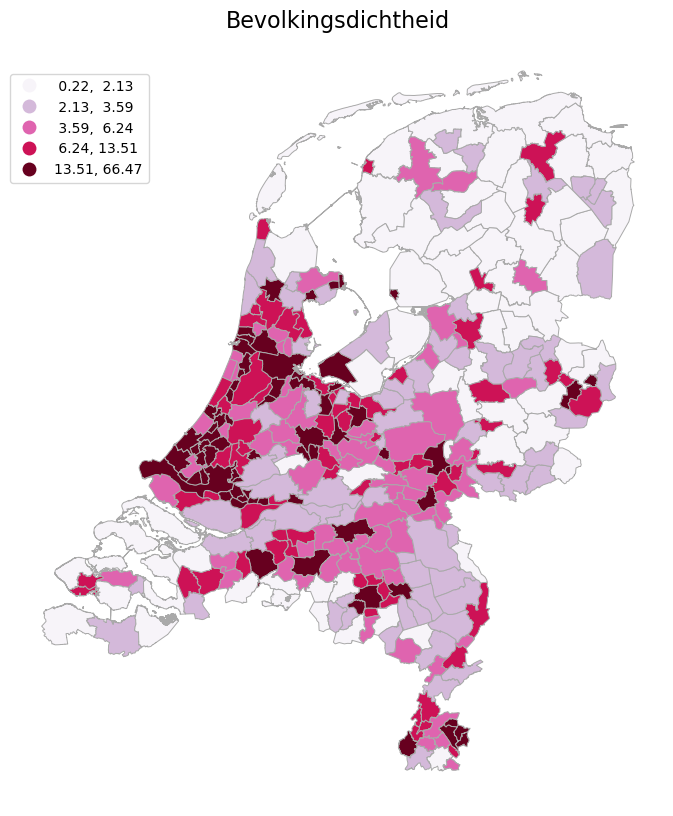

In [19]:
# plot map
column = 'Dichtheid'
title = 'Bevolkingsdichtheid'

f, ax = plt.subplots(1, figsize=(10, 10))

ax = dfm.plot(
    ax=ax, 
    linewidth=.7, 
    edgecolor='darkgrey', 
    cmap='PuRd', 
    column=column, 
    legend=True, 
    scheme='quantiles', 
    missing_kwds={'color': 'lightgrey', 'label': 'Missing values'}
)

ax.set_title(title, fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.22, -0.04, 0, 1))
plt.axis('off')
plt.show()

### Map with missing values

In [20]:
# parameters
column_to_nullify = 'Dichtheid'
null_fraction = 0.1 # 10% of the values will be set to NaN

# determine how many nulls to add
num_nulls = int(len(dfm) * null_fraction)

# randomly select indices
null_indices = np.random.choice(dfm.index, size=num_nulls, replace=False)

# set selected indices in the column to NaN
dfm.loc[null_indices, column_to_nullify] = np.nan

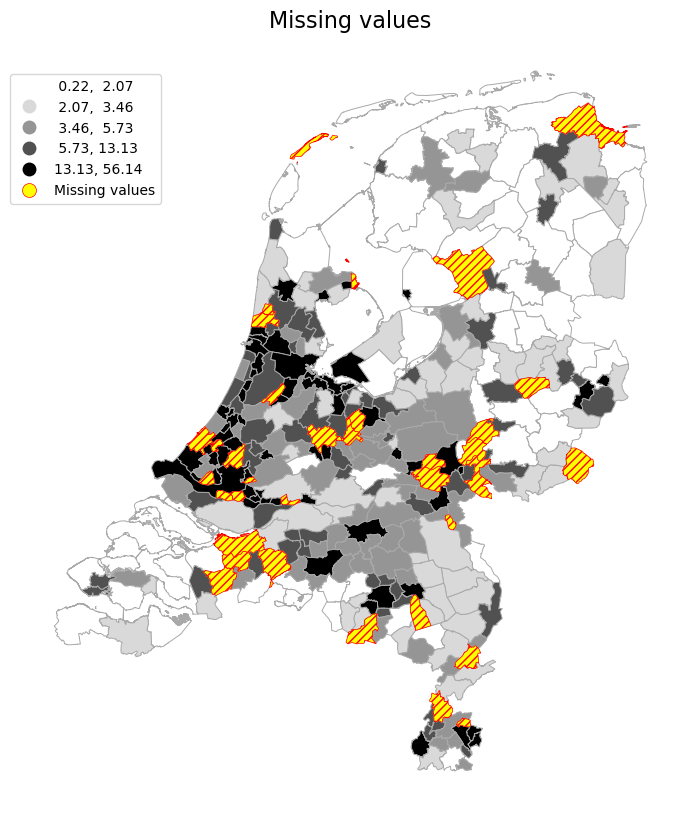

In [21]:
# plot map
column = 'Dichtheid'
title = 'Missing values'

f, ax = plt.subplots(1, figsize=(10, 10))

ax = dfm.plot(
    ax=ax, 
    linewidth=.7, 
    edgecolor='darkgrey', 
    cmap='Grays', 
    column=column, 
    legend=True, 
    scheme='quantiles', 
    missing_kwds={'color': 'yellow', 'edgecolor': 'red', 'linewidth': 0.5, "hatch": "////", 'label': 'Missing values'}
)

ax.set_title(title, fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.22, -0.04, 0, 1))
plt.axis('off')
plt.show()